In [8]:
import imgui_bundle
from imgui_bundle import implot, imgui, imgui_knobs, immapp
import time
import numpy as np

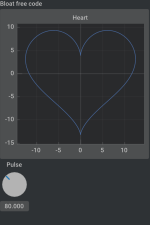

In [9]:
def haiku_heart():
    vals = np.arange(0, np.pi * 2, 0.01)
    x = np.power(np.sin(vals), 3) * 16
    y = 13 * np.cos(vals) - 5 * np.cos(2 * vals) - 2 * np.cos(3 * vals) - np.cos(4 * vals)

    phase = 0
    t0 = time.time() + 0.2
    heart_pulse_rate = 80

    def gui():
        nonlocal heart_pulse_rate, phase, t0
        t = time.time()
        phase += (t - t0) * heart_pulse_rate / (np.pi * 2)
        k = 0.8 + 0.1 * np.cos(phase)
        t0 = t
        imgui.text("Bloat free code")
        implot.begin_plot("Heart")
        implot.plot_line("", x * k, y * k)
        implot.end_plot()
        _, heart_pulse_rate = imgui_knobs.knob("Pulse", heart_pulse_rate, 30, 180)

    immapp.run_nb(gui, window_size=(300, 450), fps_idle=20, thumbnail_ratio=0.25)


haiku_heart()

In [4]:
lin = np.array([8, 8, 9, 7, 8, 8, 8, 9, 7, 8])
bar = np.array([1, 2, 5, 3, 4, 1, 2, 5, 3, 4])
dot = np.array([7, 6, 6, 7, 8, 5, 6, 5, 8, 7])


def mixed_plot():
    imgui.style_colors_light()
    if implot.begin_plot("Mixed plot"):
        implot.setup_axes("x-axis", "y-axis")
        implot.setup_axes_limits(-0.5, 9.5, 0, 10)
        implot.plot_bars("Bars", bar, 0.5)
        implot.plot_line("Line", lin)
        implot.plot_scatter("Scatter", dot)
        implot.end_plot()


immapp.run_nb(mixed_plot, window_size=(800, 500), thumbnail_height=150)

AttributeError: module 'imgui_bundle' has no attribute 'run'

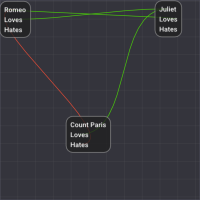

In [16]:
from imgui_bundle.demos_python.haikus.demo_node_love_triangle import Lover, Tie
from imgui_bundle import imgui_node_editor as ed


Romeo = Lover("Romeo")
Juliet = Lover("Juliet")
CountParis = Lover("Count Paris")
lovers = [Romeo, Juliet, CountParis]
links = [
    Tie(Romeo, "loves", Juliet),
    Tie(Juliet, "loves", Romeo),
    Tie(CountParis, "loves", Juliet),
    Tie(CountParis, "hates", Romeo),
    # Tie(Juliet, "hates", CountParis),
]


def gui_romeo_and_juliet():
    ed.begin("Romeo and Juliet")
    for lover in lovers:
        lover.draw()
    for link in links:
        link.draw()
    ed.end()


imgui_bundle.run_nb(
    gui_romeo_and_juliet, window_size=(450, 450), window_title="It will not end well...", thumbnail_height=200
)